# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [3]:
import random as python_random
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# Importing dataset

In [4]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train/'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val/'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test/'

In [5]:
train_num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
train_num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"train_num_pneumonia: {train_num_pneumonia}")
print(f"train_num_normal: {train_num_normal}")

val_num_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
val_num_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f"val_num_pneumonia: {val_num_pneumonia}")
print(f"val_num_normal: {val_num_normal}")

test_num_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
test_num_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f"test_num_pneumonia: {test_num_pneumonia}")
print(f"test_num_normal: {test_num_normal}")

print("")
train_num = train_num_pneumonia+train_num_normal
val_num = val_num_pneumonia+val_num_normal
test_num = test_num_pneumonia+test_num_normal
print(f"train_num: {train_num}")
print(f"val_num: {val_num}")
print(f"test_num: {test_num}")

print("")
num_pneumonia = train_num_pneumonia + test_num_pneumonia + val_num_pneumonia
num_normal = train_num_normal + test_num_normal + val_num_normal
print(f"num_pneumonia: {num_pneumonia}")
print(f"num_normal: {num_normal}")

train_num_pneumonia: 3875
train_num_normal: 1341
val_num_pneumonia: 8
val_num_normal: 8
test_num_pneumonia: 390
test_num_normal: 234

train_num: 5216
val_num: 16
test_num: 624

num_pneumonia: 4273
num_normal: 1583


## Loading data function

In [6]:
labels = ["NORMAL", "PNEUMONIA"]
img_size = 224

def load_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
                
    return np.array(data, dtype="object")

## Loading data

In [7]:
train = load_data(train_dir)
test = load_data(test_dir)
val = load_data(val_dir)

## Splitting X and y

In [8]:
X_train = [] 
y_train = []
X_test = [] 
y_test = []
X_val = [] 
y_val = []

def split_x_y(data, x, y):
    for feature, label in data:
        x.append(feature)
        y.append(label)
    return np.array(x), np.array(y)

X_train, y_train = split_x_y(train, X_train, y_train)
X_test, y_test = split_x_y(test, X_test, y_test)
X_val, y_val = split_x_y(val, X_val, y_val)

# Data augmentation layer

In [9]:
def augmentation_layers(x):
    x = keras.layers.Rescaling(1./255)(x)
    x = keras.layers.RandomRotation(0.05)(x)
    return x

# Visualizing data

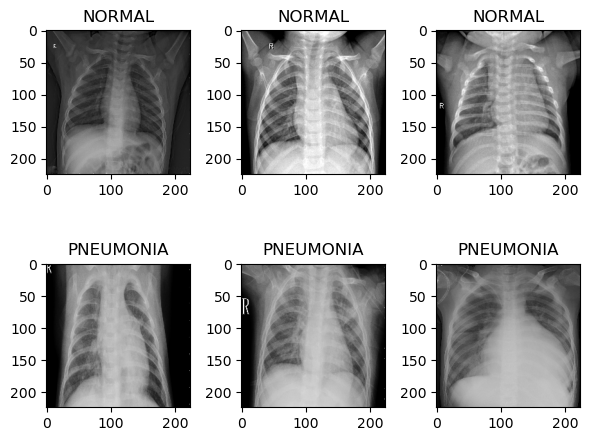

In [10]:
j=0
fig=plt.figure(figsize=(6, 6))
for i in (0,1,2,-2,-3,-4):
    fig.add_subplot(2,3,j+1)
    plt.imshow(train[i][0])
    plt.title(labels[train[i][1]])
    plt.tight_layout()
    j+=1
plt.show()

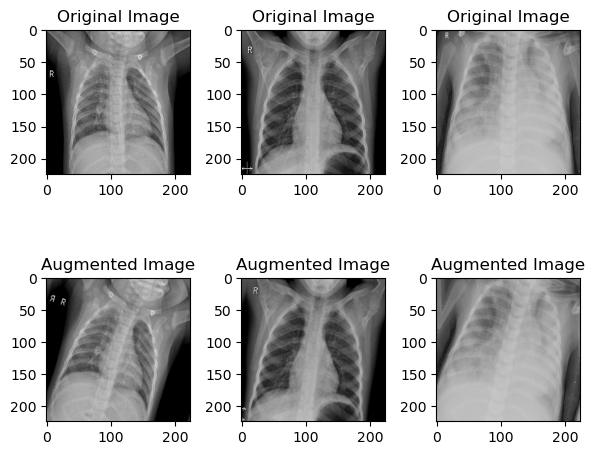

In [11]:
j=0
fig=plt.figure(figsize=(6, 6))
for i in (4,5,-1):
    fig.add_subplot(2,3,j+1)
    plt.imshow(train[i][0])
    plt.title("Original Image")
    x = augmentation_layers(train[i][0])
    fig.add_subplot(2,3,j+4)
    plt.imshow(x)
    plt.title("Augmented Image")
    plt.tight_layout()
    j+=1
plt.show()

# Calculating weights

In [12]:
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.73
Weight for class 1: 0.27


# Callbacks

In [13]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               mode='min')

# Metrics

In [14]:
def visualise_model_metrics(model, history):
    evaluation = model.evaluate(x=X_test,y=y_test)
    print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

    evaluation = model.evaluate(x=X_train,y=y_train)
    print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")
    
    plt.figure(figsize=(20,15))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label = "Training accuracy",marker='o')
    plt.plot(history.history['val_accuracy'], label="Validation accuracy",marker='o')
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(2,2,2)
    plt.plot(history.history['loss'], label = "Training loss",marker='o')
    plt.plot(history.history['val_loss'], label="Validation loss",marker='o')
    plt.legend()
    plt.title("Training vs validation loss")

    plt.show()

## Classification report function

In [15]:
def load_classification_report(y_pred):
    print('Classification report')
    print()
    print(classification_report(y_true=y_test,y_pred=y_pred, target_names=labels))

## Plotting ROC function

In [16]:
def plot_roc(y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# ResNet50

In [17]:
base_resnet50 = tf.keras.applications.ResNet50(
                    include_top=False,
                    weights="/kaggle/input/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_resnet50.layers:
        layer.trainable=False

In [18]:
inputs = keras.layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_resnet50(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(1,activation='sigmoid')(x)
resnet50 = keras.Model(inputs, predictions)

In [19]:
resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [20]:
checkpoint_resnet50 = '/kaggle/working/resnet50_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_resnet50,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_res50 = resnet50.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

resnet50.load_weights(checkpoint_resnet50)

Epoch 1/30
163/163 [==============================] - 468s 3s/step - loss: 0.0969 - accuracy: 0.8900 - val_loss: 0.5410 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 448s 3s/step - loss: 0.0617 - accuracy: 0.9381 - val_loss: 0.1693 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 453s 3s/step - loss: 0.0522 - accuracy: 0.9452 - val_loss: 0.1559 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - 442s 3s/step - loss: 0.0482 - accuracy: 0.9528 - val_loss: 0.1409 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 441s 3s/step - loss: 0.0437 - accuracy: 0.9546 - val_loss: 0.0862 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 6/30
163/163 [==============================] - 438s 3s/step - loss: 0.0464 - accuracy: 0.9517 - val_loss: 0.0934 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 7/30
163/163 [====================

20/20 [==============================] - 56s 3s/step - loss: 0.2797 - accuracy: 0.8990
Test Accuracy: 89.90%
163/163 [==============================] - 463s 3s/step - loss: 0.2068 - accuracy: 0.9087
Train Accuracy: 90.87%


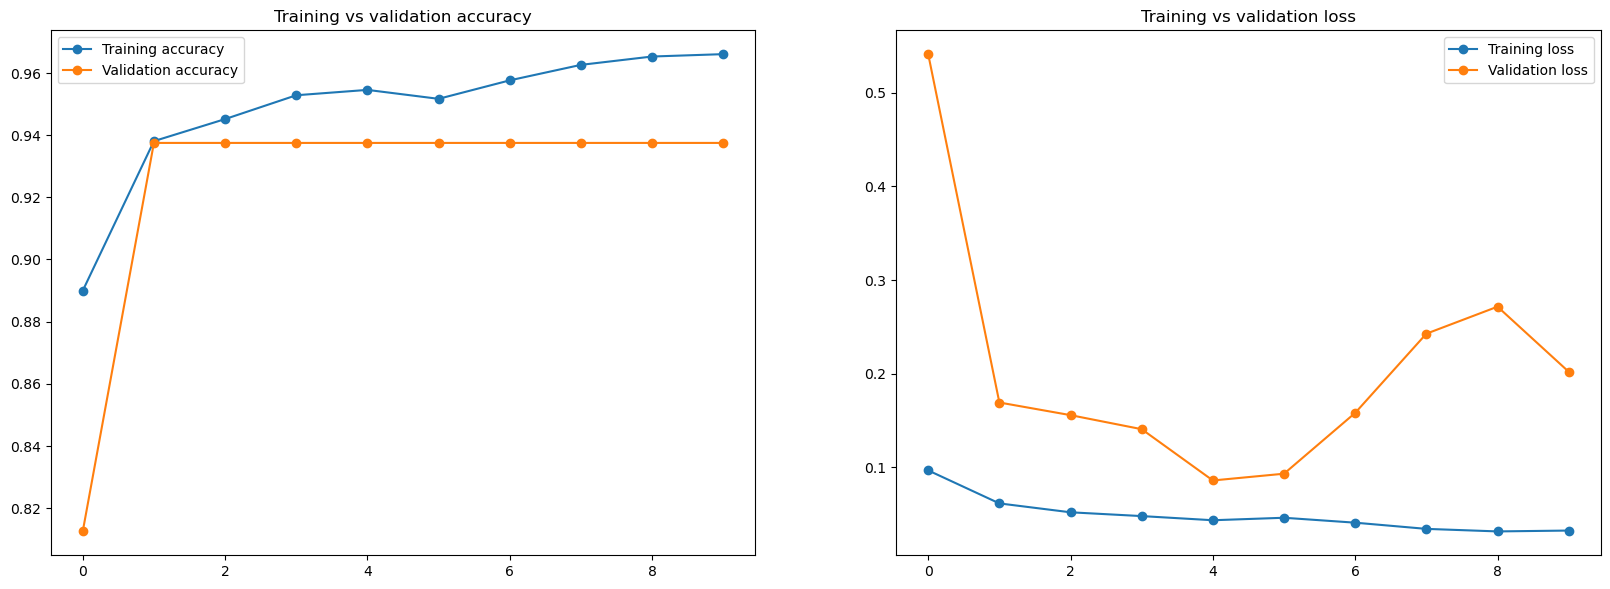

In [21]:
visualise_model_metrics(resnet50, history_res50)

20/20 [==============================] - 56s 3s/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.86      0.87      0.87       234
   PNEUMONIA       0.92      0.92      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



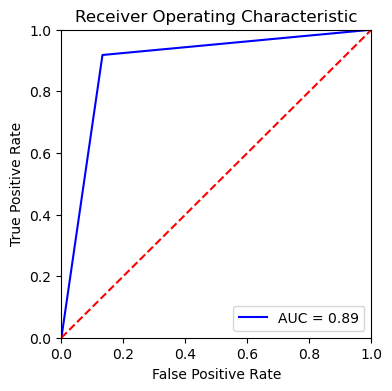

In [22]:
pred = resnet50.predict(X_test)
resnet50_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(resnet50_pred)
plot_roc(resnet50_pred)

# ResNet101

In [23]:
base_resnet101 = tf.keras.applications.ResNet101(
                    include_top=False,
                    weights="/kaggle/input/weights101/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_resnet101.layers:
        layer.trainable=False

In [24]:
inputs = keras.layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_resnet101(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
resnet101 = keras.Model(inputs, predictions)

In [25]:
resnet101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [26]:
checkpoint_resnet101 = '/kaggle/working/resnet101_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_resnet101,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_resnet101 = resnet101.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

resnet101.load_weights(checkpoint_resnet101)

Epoch 1/30
163/163 [==============================] - 794s 5s/step - loss: 0.1060 - accuracy: 0.8829 - val_loss: 0.3091 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 789s 5s/step - loss: 0.0664 - accuracy: 0.9306 - val_loss: 0.2392 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 782s 5s/step - loss: 0.0589 - accuracy: 0.9362 - val_loss: 0.2983 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9473
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
163/163 [==============================] - 790s 5s/step - loss: 0.0505 - accuracy: 0.9473 - val_loss: 0.3209 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 792s 5s/step - loss: 0.0454 - accuracy: 0.9517 - val_loss: 0.2876 - val_accuracy: 0.9375 - lr: 6.0000e-05
Epoch 6/30
163/163 [===================

20/20 [==============================] - 92s 4s/step - loss: 0.3678 - accuracy: 0.8830
Test Accuracy: 88.30%
163/163 [==============================] - 751s 5s/step - loss: 0.1077 - accuracy: 0.9597
Train Accuracy: 95.97%


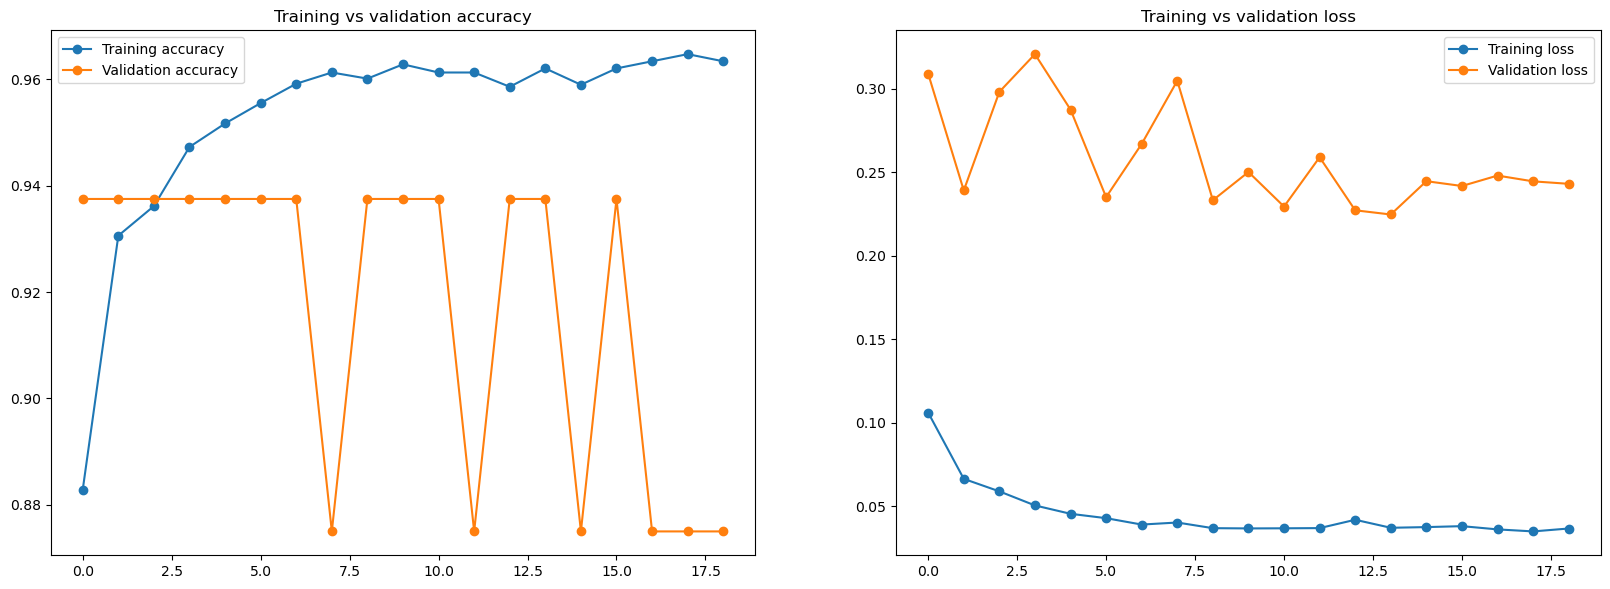

In [27]:
visualise_model_metrics(resnet101, history_resnet101)

20/20 [==============================] - 106s 5s/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.94      0.74      0.83       234
   PNEUMONIA       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



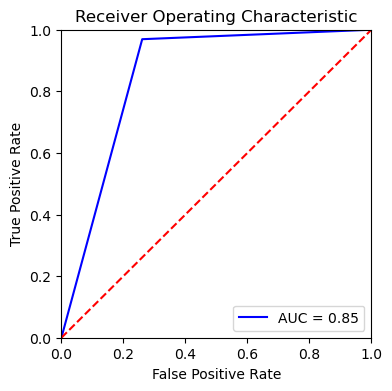

In [28]:
pred = resnet101.predict(X_test)
resnet101_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(resnet101_pred)
plot_roc(resnet101_pred)

# DenseNet121

In [29]:
base_densenet121 = tf.keras.applications.DenseNet121(
                    include_top=False,
                    weights="/kaggle/input/weights-desnse121/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_densenet121.layers:
        layer.trainable=False

In [30]:
inputs = layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_densenet121(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
densenet121 = keras.Model(inputs, predictions)

In [31]:
densenet121.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [32]:
checkpoint_densenet121 = '/kaggle/working/densenet121_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_densenet121,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_densenet121 = densenet121.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

densenet121.load_weights(checkpoint_densenet121)

Epoch 1/30
163/163 [==============================] - 443s 3s/step - loss: 0.2774 - accuracy: 0.7090 - val_loss: 0.9074 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 423s 3s/step - loss: 0.1626 - accuracy: 0.8219 - val_loss: 0.9823 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.8447
Epoch 3: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
163/163 [==============================] - 427s 3s/step - loss: 0.1389 - accuracy: 0.8447 - val_loss: 1.0711 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - 439s 3s/step - loss: 0.1190 - accuracy: 0.8748 - val_loss: 1.0748 - val_accuracy: 0.6250 - lr: 6.0000e-05
Epoch 5/30
163/163 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.8752
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.2000000424450263e-05.
163/163 [=================

20/20 [==============================] - 53s 2s/step - loss: 0.4464 - accuracy: 0.8253
Test Accuracy: 82.53%
163/163 [==============================] - 421s 3s/step - loss: 0.3512 - accuracy: 0.8660
Train Accuracy: 86.60%


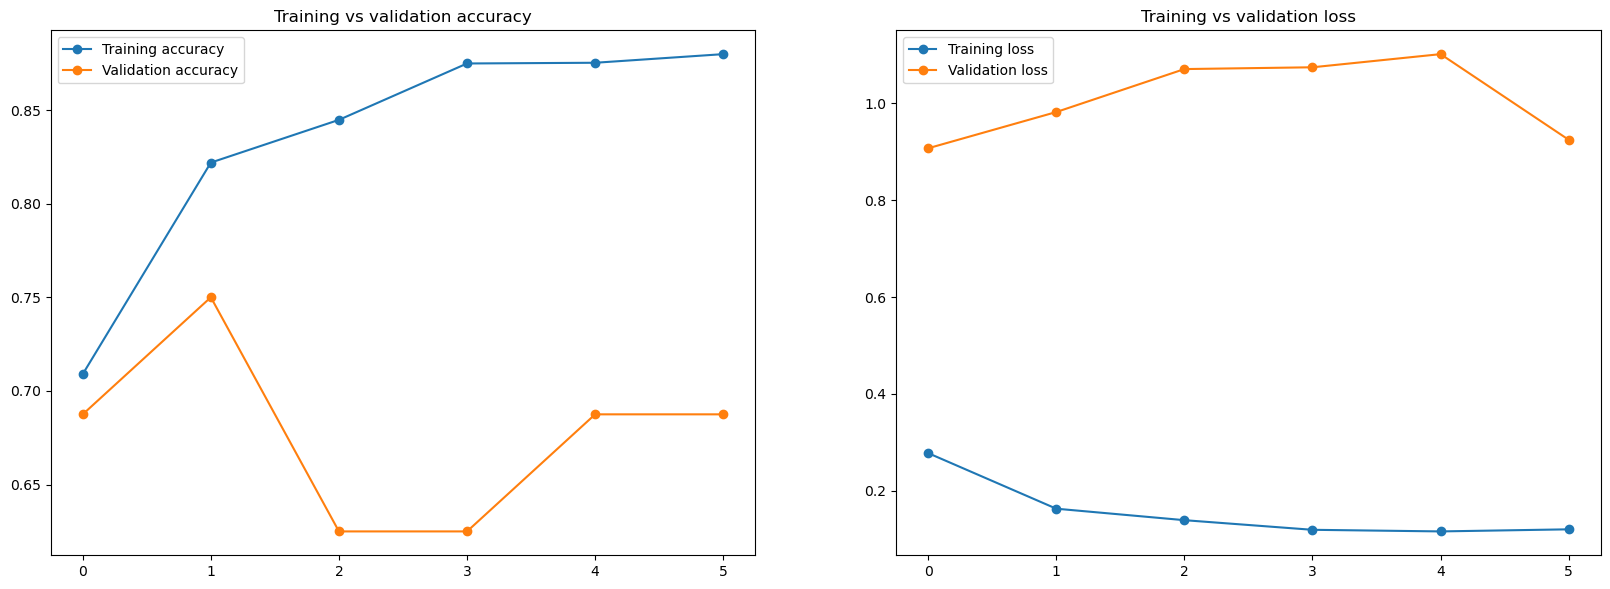

In [33]:
visualise_model_metrics(densenet121, history_densenet121)

20/20 [==============================] - 54s 3s/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.75      0.79      0.77       234
   PNEUMONIA       0.87      0.84      0.86       390

    accuracy                           0.83       624
   macro avg       0.81      0.82      0.82       624
weighted avg       0.83      0.83      0.83       624



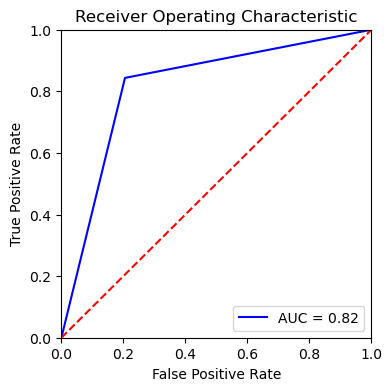

In [34]:
pred = densenet121.predict(X_test)
densenet121_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(densenet121_pred)
plot_roc(densenet121_pred)

# Metrics comparison

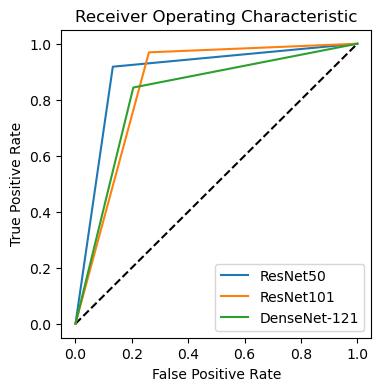

In [35]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, resnet50_pred)
fpr2, tpr2, thresholds2 = roc_curve(y_test, resnet101_pred)
fpr4, tpr4, thresholds4 = roc_curve(y_test, densenet121_pred)

plt.figure(figsize=(4, 4))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "ResNet50")
plt.plot(fpr2, tpr2, label= "ResNet101")
plt.plot(fpr4, tpr4, label= "DenseNet-121")

plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic')
plt.show()

In [36]:
def print_scores(y_pred):    
    accuracy  = accuracy_score(y_test, y_pred)
    precision  = precision_score(y_test, y_pred)
    recall  = recall_score( y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    roc  = roc_auc_score(y_test, y_pred)
    print("Accuarcy Score: ", format(accuracy*100, '.2f'))
    print("Precision Score: ", format(precision*100, '.2f'))
    print("Recall Score: ", format(recall*100, '.2f'))
    print("F1 Score: ", format(f1*100, '.2f'))
    print("ROC AUC Score: ", format(roc*100, '.2f'))
    print("")

In [37]:
print("ResNet50")
print_scores(resnet50_pred)
print("ResNet101")
print_scores(resnet101_pred)
print("DenseNet-121")
print_scores(densenet121_pred)

ResNet50
Accuarcy Score:  89.90
Precision Score:  92.03
Recall Score:  91.79
F1 Score:  91.91
ROC AUC Score:  89.27

ResNet101
Accuarcy Score:  88.30
Precision Score:  86.10
Recall Score:  96.92
F1 Score:  91.19
ROC AUC Score:  85.43

DenseNet-121
Accuarcy Score:  82.53
Precision Score:  87.27
Recall Score:  84.36
F1 Score:  85.79
ROC AUC Score:  81.92

